In [65]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import random
import math
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score
import datetime
import operator 
plt.style.use('fivethirtyeight')
%matplotlib inline

In [66]:
recovered_cases = pd.read_csv('C:/Users/Surya/Desktop/Mini Project/COVID-19-master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
cols = recovered_cases.keys()
recoveries = recovered_cases.loc[:, cols[4]:cols[66]]
dates = recoveries.keys()
world_cases = []

for i in dates:
    recoveries_sum = recoveries[i].sum()
    world_cases.append(recoveries_sum)
  


days_since_1_22 = np.array([i for i in range(len(dates))])
#world_cases = np.array(world_cases).reshape(-1, 1)

days_in_future = 10
future_forecast = np.array([i for i in range(len(dates)+days_in_future)]).reshape(-1, 1)
adjusted_dates = future_forecast[:-10]


In [67]:
mycases=pd.DataFrame({"dates":days_since_1_22,"cases":world_cases})
mycases=mycases.set_index("dates")
rolmean=pd.DataFrame(mycases['cases']).rolling(window=3).mean()
print(rolmean)

               cases
dates               
0                NaN
1                NaN
2          31.333333
3          35.000000
4          42.333333
...              ...
58      85227.333333
59      88010.333333
60      92319.333333
61      95968.666667
62     101409.333333

[63 rows x 1 columns]


In [68]:
rolmean['cases'].fillna(555, inplace=True)
print(rolmean['cases'].isnull().sum())


0


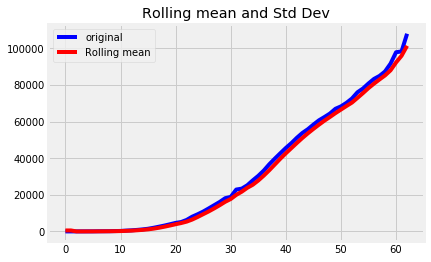

In [69]:
orig=plt.plot(mycases,color="blue",label="original")
mean=plt.plot(rolmean,color="red",label="Rolling mean")
plt.legend(loc="best")
plt.title("Rolling mean and Std Dev")
plt.show(block=False)

In [70]:
train_len = int(np.ceil(len(mycases) * 0.90))
print(len(mycases)-train_len)

6


In [71]:
train_data=rolmean[0:train_len] 
test_data=rolmean[train_len:]
print('Train data length :',len(train_data))
print('Test  data length :',len(test_data))

Train data length : 57
Test  data length : 6


In [72]:
x_train = train_data.drop('cases', axis=1)
x_test = test_data.drop('cases', axis=1)
y_train = train_data[['cases']]
y_test = test_data[['cases']]

In [73]:
SES = SimpleExpSmoothing(train_data['cases'])

In [74]:
root_mean=[]
mean_abs=[]
level=[]

In [75]:
for i in np.arange(0.1,1.1,0.1):
    SES_fit = SES.fit(smoothing_level=i,optimized=False)
    SES_predictions = SES_fit.forecast(len(test_data['cases']))
    rmse = np.sqrt(mean_squared_error(test_data.cases, SES_predictions))
    rmse = round(rmse, 3)
    absolute_err = np.abs(y_test['cases']-SES_predictions)
    mape = np.round(np.mean(absolute_err/y_test['cases']),4)
    root_mean.append(mape)
    mean_abs.append(np.round(rmse,2))
    level.append(np.round(i,1))
    print('smoothing_level : ',np.round(i,1),'RMSE : ' ,np.round(rmse,2) ,'MAPE : ',mape)

smoothing_level :  0.1 RMSE :  31652.14 MAPE :  0.3377
smoothing_level :  0.2 RMSE :  20807.97 MAPE :  0.2141
smoothing_level :  0.3 RMSE :  17149.47 MAPE :  0.1712
smoothing_level :  0.4 RMSE :  15337.74 MAPE :  0.1495
smoothing_level :  0.5 RMSE :  14239.14 MAPE :  0.1361
smoothing_level :  0.6 RMSE :  13499.16 MAPE :  0.1269
smoothing_level :  0.7 RMSE :  12970.24 MAPE :  0.1202
smoothing_level :  0.8 RMSE :  12577.61 MAPE :  0.1152
smoothing_level :  0.9 RMSE :  12278.14 MAPE :  0.1114
smoothing_level :  1.0 RMSE :  12044.84 MAPE :  0.1084


In [76]:
level_optim=level[root_mean.index(min(root_mean))]
print("Optimal value of Smoothing level is ",level_optim)

Optimal value of Smoothing level is  1.0


In [77]:
SES_fit = SES.fit(smoothing_level=level_optim,optimized=True)
SES_fit.params

{'smoothing_level': 1.0,
 'smoothing_slope': nan,
 'smoothing_seasonal': nan,
 'damping_slope': nan,
 'initial_level': 555.0,
 'initial_slope': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [78]:
SES_predictions = SES_fit.forecast(len(y_test['cases']))

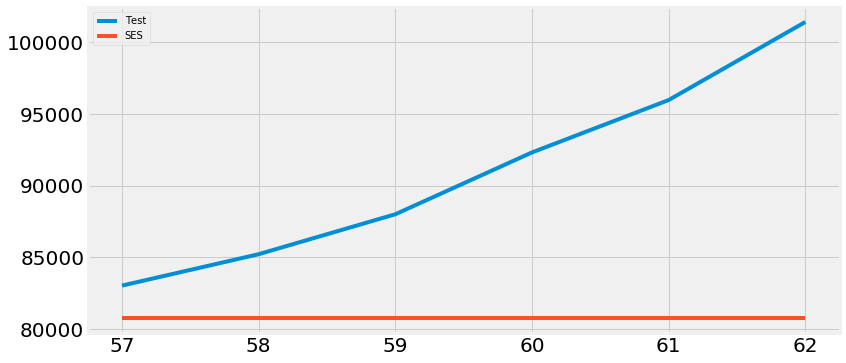

In [79]:
plt.figure(figsize=(12,6))
plt.plot(test_data['cases'], label='Test')
plt.plot(SES_predictions, label='SES')
plt.xticks(size=20)
plt.yticks(size=20)
plt.legend(loc='best')

In [80]:
from statsmodels.tsa.api import Holt
HOLT_model = Holt(np.asarray(train_data['cases']),exponential=True).fit(smoothing_level=level_optim,smoothing_slope=1,damping_slope=1, optimized=True)
HOLT_model.params

{'smoothing_level': 1.0,
 'smoothing_slope': 1.0,
 'smoothing_seasonal': nan,
 'damping_slope': nan,
 'initial_level': 555.0,
 'initial_slope': 1.0,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [81]:
HOLT_predictions = HOLT_model.forecast(len(test_data))

In [82]:
ESPred=HOLT_model.forecast(73)

In [83]:
#exponentialsmoothing
print('MAE:{}  || Actual Values: 1827 '.format(mean_absolute_error(HOLT_predictions, test_data['cases'])))
print('MSE:{}  || Actual Values: 5970634 '.format(mean_squared_error(HOLT_predictions, test_data['cases'])))

MAE:1449.3133224675184  || Actual Values: 1827 
MSE:4149061.2113305773  || Actual Values: 5970634 


In [84]:
test_data['HOLT']=HOLT_predictions

G:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [85]:
test_data

,cases,HOLT
dates,,
57,83039.000000,83253.375135
58,85227.333333,85836.130423
59,88010.333333,88499.010088
60,92319.333333,91244.499816
61,95968.666667,94075.162405
62,101409.333333,96993.640157


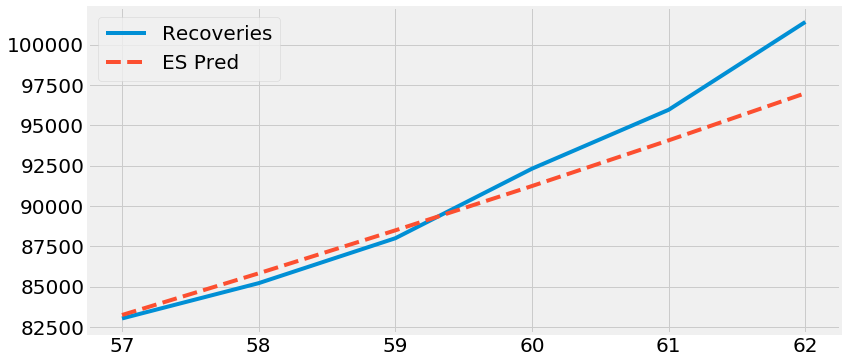

In [86]:
plt.figure(figsize=(12,6))
plt.plot(test_data['cases'], label='Test')
plt.plot(test_data['HOLT'], label='HOLT',linestyle='dashed')
plt.legend(['Recoveries', 'ES Pred'], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [87]:
def plot_predictions(x, y, pred, algo_name):
    plt.figure(figsize=(16, 9))
    plt.plot(x, y)
    plt.plot(future_forecast, pred, linestyle='dashed', color='red')
    plt.title('Number of  recovered cases Over Time', size=30)
    plt.xlabel('Days Since 1/22/2020', size=30)
    plt.ylabel('Number of recoveries', size=30)
    plt.legend(['recoveries', algo_name], prop={'size': 20})
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.show()

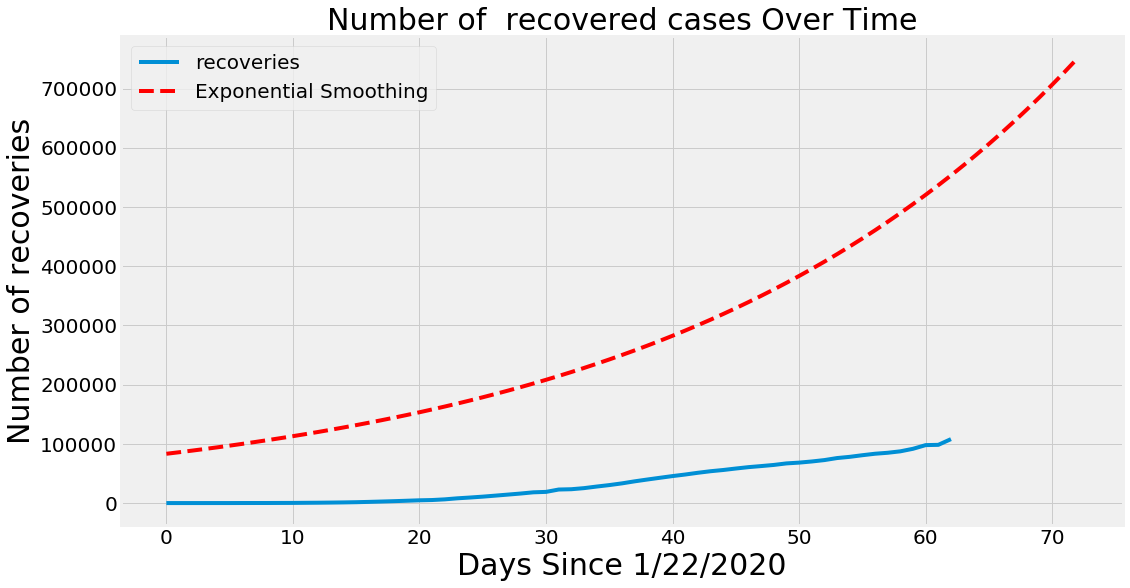

In [88]:
plot_predictions(adjusted_dates,world_cases, ESPred, 'Exponential Smoothing')